In [1]:
!git clone https://github.com/muxspace/facial_expressions.git


Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 44.05 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/facial_expressions/data/legend.csv')
df.head(10)

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral
5,302,Aaron_Guiel_0001.jpg,happiness
6,302,Aaron_Patterson_0001.jpg,neutral
7,302,Aaron_Peirsol_0001.jpg,happiness
8,302,Aaron_Peirsol_0002.jpg,happiness
9,302,Aaron_Peirsol_0003.jpg,happiness


In [7]:
df.emotion = df.emotion.str.lower()
df.emotion.unique()

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt'], dtype=object)

# New section

In [4]:
import os
dir = os.listdir('/content/facial_expressions/images')
image_dir = '/content/facial_expressions/images'

fig = plt.figure(figsize=(40, 40))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.axis('off')
  img = plt.imread(os.path.join(image_dir, df.image[i]))
  plt.title(df.emotion[i], fontsize=30) 
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [5]:
#no of class names
classes = set(df.emotion.str.lower())
classes

{'anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise'}

In [33]:
from collections import defaultdict
emotions_list = defaultdict(list)

In [37]:

for index, emotion in enumerate(df.emotion):
  key = emotion
  emotions_list[key].append(df.image[index])
print(len(emotions_list['anger']))

756


In [39]:
import os
os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')
temp = ['training', 'testing']
for temp in temp:
  for key in emotions_list.keys():
    os.mkdir(os.path.join('master_data/' + temp, key))




In [40]:
print(os.listdir('master_data/training'))

['sadness', 'happiness', 'fear', 'anger', 'disgust', 'contempt', 'neutral', 'surprise']


In [41]:
from shutil import copyfile
train_dir ='/content/master_data/training'
test_dir = '/content/master_data/testing'
for emotion, images in emotions_list.items():
  train_size = int(len(images)*0.8)
  train_images = images[:train_size]
  test_images = images[train_size:]
  for image in train_images:
    src = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join(train_dir, emotion, image)
    copyfile(src, dest)
  for image in test_images:
    src = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join(test_dir, emotion, image)
    copyfile(src, dest)

In [44]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping

In [50]:
model = keras.models.Sequential([

      Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),

      Conv2D(32, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),

      Flatten(),
      Dense(512, activation='relu'),
      Dense(8, activation='softmax')

])

In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

In [54]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(28, 28)
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(28, 28)
)


Found 13683 images belonging to 8 classes.
Found 8210 images belonging to 8 classes.


In [55]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_acc')

In [56]:
history = model.fit(train_generator,
                    epochs=10,
                    callbacks=[callback],
                    validation_data=test_generator)

Epoch 1/10
428/428 [==============================] - 27s 47ms/step - loss: 0.9696 - accuracy: 0.6818 - val_loss: 0.6088 - val_accuracy: 0.7833
Epoch 2/10
428/428 [==============================] - 20s 47ms/step - loss: 0.5299 - accuracy: 0.8134 - val_loss: 0.4870 - val_accuracy: 0.8143
Epoch 3/10
428/428 [==============================] - 20s 47ms/step - loss: 0.4236 - accuracy: 0.8490 - val_loss: 0.4946 - val_accuracy: 0.8140
Epoch 4/10
428/428 [==============================] - 20s 46ms/step - loss: 0.3288 - accuracy: 0.8814 - val_loss: 0.2306 - val_accuracy: 0.9136
Epoch 5/10
428/428 [==============================] - 20s 46ms/step - loss: 0.2304 - accuracy: 0.9182 - val_loss: 0.2100 - val_accuracy: 0.9319
Epoch 6/10
428/428 [==============================] - 20s 47ms/step - loss: 0.1578 - accuracy: 0.9426 - val_loss: 0.1379 - val_accuracy: 0.9481
Epoch 7/10
428/428 [==============================] - 20s 47ms/step - loss: 0.0988 - accuracy: 0.9687 - val_loss: 0.1324 - val_accuracy:

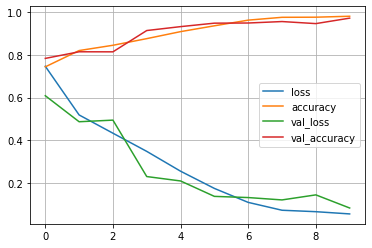

In [61]:
df = pd.DataFrame(data=history.history)
df.plot(grid=True)